# data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import tensorflow as tf
color_pal = sns.color_palette()

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotUniform

In [2]:
def get_df(MeterCategory):

    df = pd.read_csv("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv")

    undesired_meter_categories = ['Storage', 'Virtual Machines', 'Automation', 'Bandwidth', 'Load Balancer', 'Log Analytics', 'Service Bus', 'Logic Apps'] 

    # Define the MeterCategories you want to select as a list
    desired_meter_categories = [MeterCategory]  # Add your desired categories

    # Select rows where 'MeterCategory' matches the desired names
    if (MeterCategory == 'Others'):
        df = df[-df['MeterCategory'].isin(undesired_meter_categories)]
    else:
        df = df[df['MeterCategory'].isin(desired_meter_categories)]

    # Rest of your data processing code
    columns_to_eliminate = ['InvoiceSectionName', 'MeterCategory', 'MeterSubCategory', 'MeterName', 'SubscriptionName', 'ResourceGroup', 'ConsumedService', 'ResourceLocation', 'ResourceName']

    # Mapping categorical features (if needed)

    df.drop(columns=columns_to_eliminate, inplace=True)
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index)

    df['DayOfWeek'] = df.index.day_of_week
    df['Month'] = df.index.month

    df['CostInBillingCurrency'] = df.groupby(df.index.date)['CostInBillingCurrency'].sum()
    df = df.drop_duplicates(subset=['CostInBillingCurrency'])
    df = df.sort_index()
    return df

In [3]:
df = pd.read_csv("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv")

# Define the MeterCategories you want to select as a list
#desired_meter_categories = ['Storage', 'Virtual Machines', 'Automation', 'Bandwidth', 'Load Balancer', 'Log Analytics', 'Service Bus', 'Logic Apps']  # Add your desired categories

# Select rows where 'MeterCategory' matches the desired names
#df = df[df['MeterCategory'].isin(desired_meter_categories)]

# Rest of your data processing code
columns_to_eliminate = ['InvoiceSectionName', 'MeterCategory', 'MeterSubCategory', 'MeterName', 'SubscriptionName', 'ResourceGroup', 'ConsumedService', 'ResourceLocation', 'ResourceName']

# Mapping categorical features (if needed)

df.drop(columns=columns_to_eliminate, inplace=True)
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)

df['DayOfWeek'] = df.index.day_of_week
df['Month'] = df.index.month

df['CostInBillingCurrency'] = df.groupby(df.index.date)['CostInBillingCurrency'].sum()
df = df.drop_duplicates(subset=['CostInBillingCurrency'])
df = df.sort_index()

Y = df['CostInBillingCurrency'][4:].values

walk_train_y = []
walk_val_y = []
walk_test_y = []

for i in range (5):

    delay = i*5

    walk_train_y.append(Y[delay:50+delay])
    walk_val_y.append(Y[50+delay:60+delay])
    walk_test_y.append(Y[60+delay:65+delay])

In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

In [6]:
def add_element(data, element):
  DataSet = np.empty((data.shape[0], data.shape[1] + 1))
  for i in range(data.shape[0]):
      nuova_riga = np.append(data[i], element[i])
      DataSet[i] = nuova_riga
  return DataSet

In [7]:
def da(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the sign of the difference between consecutive actual values
    actual_diff = np.sign(y_true[1:] - y_true[:-1])
    
    # Calculate the sign of the difference between the predicted value and the actual value of the previous day
    pred_diff = np.sign(y_pred[1:] - y_true[:-1])
    
    # Calculate the number of times the signs are the same
    num_correct = np.sum(actual_diff == pred_diff)
    
    # Calculate the total number of comparisons (which is one less than the length of the time series)
    total_comparisons = len(y_true) - 1
    
    # Calculate the directional accuracy
    da = num_correct / total_comparisons
    
    return da

In [45]:
def create_train_test_val(df):

    seq_length = 6

    if(len(df) == 89):
        if (seq_length == 4):
            train = 50
        elif (seq_length == 2):
            train = 52
        elif (seq_length == 6):
            train = 48
        val = train+10
        test = train+15
    else:
        train = 50-(85-(len(df)-4))
        if (seq_length == 4):
            train = train
        elif (seq_length == 2):
            train += 2
        elif (seq_length == 6):
            train -= 2

        val = train+10
        test = train+15

    data = df['CostInBillingCurrency'].values
    data = create_sequences(data, seq_length)

    week = df['DayOfWeek'][seq_length:].values
    month = df['Month'][seq_length:].values
    data = data.reshape(len(data), seq_length)

    data = add_element(data, week)
    data = add_element(data, month)

    Y = df['CostInBillingCurrency'][seq_length:].values

    walk_train_x = []
    walk_val_x = []
    walk_test_x = []

    walk_train_y = []
    walk_val_y = []
    walk_test_y = []

    delay = 0


    # divisione dei passi
    for i in range (5):

        delay = i*5

        walk_train_x.append(data[delay:train+delay])
        walk_val_x.append(data[train+delay:val+delay])
        walk_test_x.append(data[val+delay:test+delay])

        walk_train_y.append(Y[delay:train+delay])
        walk_val_y.append(Y[train+delay:val+delay])
        walk_test_y.append(Y[val+delay:test+delay])

    return walk_train_x, walk_train_y, walk_val_x, walk_val_y, walk_test_x, walk_test_y, data

In [46]:
storage = get_df('Storage')
storage_walk_train_x, storage_walk_train_y, storage_walk_val_x, storage_walk_val_y, storage_walk_test_x, storage_walk_test_y, storage_data= create_train_test_val(storage)

In [47]:
virtual_machines = get_df('Virtual Machines')
virtual_machines_walk_train_x, virtual_machines_walk_train_y, virtual_machines_walk_val_x, virtual_machines_walk_val_y, virtual_machines_walk_test_x, virtual_machines_walk_test_y, virtual_machines_data = create_train_test_val(virtual_machines)

In [48]:
automation = get_df('Automation')
automation_walk_train_x, automation_walk_train_y, automation_walk_val_x, automation_walk_val_y, automation_walk_test_x, automation_walk_test_y, automation_data = create_train_test_val(automation)

In [49]:
bandwidth = get_df('Bandwidth')
bandwidth_walk_train_x, bandwidth_walk_train_y, bandwidth_walk_val_x, bandwidth_walk_val_y, bandwidth_walk_test_x, bandwidth_walk_test_y, bandwidth_data = create_train_test_val(bandwidth)

In [50]:
load_balancer = get_df('Load Balancer')
load_balancer_walk_train_x, load_balancer_walk_train_y, load_balancer_walk_val_x, load_balancer_walk_val_y, load_balancer_walk_test_x, load_balancer_walk_test_y, load_balancer_data = create_train_test_val(load_balancer)

In [51]:
log_analytics = get_df('Log Analytics')
log_analytics_walk_train_x, log_analytics_walk_train_y, log_analytics_walk_val_x, log_analytics_walk_val_y, log_analytics_walk_test_x, log_analytics_walk_test_y, log_analytics_data = create_train_test_val(log_analytics)

In [52]:
logic_apps = get_df('Logic Apps')
logic_apps_walk_train_x, logic_apps_walk_train_y, logic_apps_walk_val_x, logic_apps_walk_val_y, logic_apps_walk_test_x, logic_apps_walk_test_y, logic_apps_data = create_train_test_val(logic_apps)

In [53]:
service_bus = get_df('Service Bus')
service_bus_walk_train_x, service_bus_walk_train_y, service_bus_walk_val_x, service_bus_walk_val_y, service_bus_walk_test_x, service_bus_walk_test_y, service_bus_data = create_train_test_val(service_bus)

In [54]:
remaining = get_df('Others')
remaining_walk_train_x, remaining_walk_train_y, remaining_walk_val_x, remaining_walk_val_y, remaining_walk_test_x, remaining_walk_test_y, remaining_data = create_train_test_val(remaining)

In [55]:
def custom_loss(y_true, y_pred):

    rmse_w = 0.5
    da_w = 0.5

    # Calculate RMSE
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true)))
    
    # Calculate directional accuracy
    actual_diff = K.sign(y_true[1:] - y_true[:-1])
    pred_diff = K.sign(y_pred[1:] - y_true[:-1])
    num_correct = K.sum(K.cast(K.equal(actual_diff, pred_diff), tf.float32))
    total_comparisons = K.cast(K.shape(y_true)[0] - 1, tf.float32)
    da = num_correct / total_comparisons
    da = 1-da

    # Normalize RMSE and directional accuracy
    rmse_normalized = rmse / (K.max(y_true) - K.min(y_true))
    
    # Combine normalized RMSE and directional accuracy with weights
    loss = (rmse_normalized * rmse_w) + (da * da_w)
    
    return loss

# Metamodel

In [20]:
model_storage = tf.keras.models.load_model('/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/Singoli modelli su dati scomposti poi sommati/Models_6_step/model_storage_6_step', custom_objects={'custom_loss': custom_loss})
model_virtual_machines = tf.keras.models.load_model("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/Singoli modelli su dati scomposti poi sommati/Models_6_step/model_virtual_machines_6_step", custom_objects={'custom_loss': custom_loss})  
model_automation = tf.keras.models.load_model("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/Singoli modelli su dati scomposti poi sommati/Models_6_step/model_automation_6_step", custom_objects={'custom_loss': custom_loss})
model_logic_apps = tf.keras.models.load_model("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/Singoli modelli su dati scomposti poi sommati/Models_6_step/model_logic_apps_6_step", custom_objects={'custom_loss': custom_loss})  
model_log_analytics = tf.keras.models.load_model("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/Singoli modelli su dati scomposti poi sommati/Models_6_step/model_log_analytics_6_step", custom_objects={'custom_loss': custom_loss})
model_bandwidth = tf.keras.models.load_model("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/Singoli modelli su dati scomposti poi sommati/Models_6_step/model_bandwidth_6_step", custom_objects={'custom_loss': custom_loss})  
model_load_balancer = tf.keras.models.load_model("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/Singoli modelli su dati scomposti poi sommati/Models_6_step/model_load_balancer_6_step", custom_objects={'custom_loss': custom_loss})
model_service_bus = tf.keras.models.load_model("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/Singoli modelli su dati scomposti poi sommati/Models_6_step/model_service_bus_6_step", custom_objects={'custom_loss': custom_loss}) 
model_remaining = tf.keras.models.load_model("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/Singoli modelli su dati scomposti poi sommati/Models_6_step/model_remaining_6_step", custom_objects={'custom_loss': custom_loss})  

In [115]:
DF_METAMODEL = pd.DataFrame()
DF_METAMODEL['ground_truth'] = df['CostInBillingCurrency'][13:]
DF_METAMODEL['storage'] = 0
DF_METAMODEL['virtual_machines'] = 0
DF_METAMODEL['automation'] = 0
DF_METAMODEL['logic_apps'] = 0
DF_METAMODEL['log_analytics'] = 0
DF_METAMODEL['bandwidth'] = 0
DF_METAMODEL['load_balancer'] = 0
DF_METAMODEL['service_bus'] = 0
DF_METAMODEL['Others'] = 0

In [116]:
DF_METAMODEL['storage'] = model_storage.predict(storage_data[7:])
DF_METAMODEL['virtual_machines'] = model_virtual_machines.predict(virtual_machines_data[:])
DF_METAMODEL['automation'] = model_automation.predict(automation_data[4:])
DF_METAMODEL['logic_apps'] = model_logic_apps.predict(logic_apps_data[7:])
DF_METAMODEL['log_analytics'] = model_log_analytics.predict(log_analytics_data[7:])
DF_METAMODEL['bandwidth'] = model_bandwidth.predict(bandwidth_data[7:])
DF_METAMODEL['load_balancer'] = model_load_balancer.predict(load_balancer_data[2:])
DF_METAMODEL['service_bus'] = model_service_bus.predict(service_bus_data[1:])
DF_METAMODEL['Others'] = model_remaining.predict(remaining_data[7:])

3/3 [==============================] - 0s 7ms/step


In [117]:
DF_METAMODEL

,ground_truth,storage,virtual_machines,automation,logic_apps,log_analytics,bandwidth,load_balancer,service_bus,Others
Date,,,,,,,,,,
2023-01-04,74.341606,21.974768,17.788820,0.009893,0.452238,0.371140,0.039424,4.345389,-0.021395,51.976650
2023-01-05,78.334315,21.976513,17.787376,0.009981,0.465868,0.371140,0.039456,4.350017,-0.023449,51.913437
2023-01-06,78.295045,21.977533,17.786873,0.009971,0.481132,0.371140,0.039490,4.323183,-0.005920,51.939842
2023-01-07,78.387020,21.978365,17.786749,0.009955,0.498212,0.371140,0.039525,4.306262,0.007638,52.075932
2023-01-08,78.323589,21.977049,17.786945,0.009933,0.517563,0.371140,0.039559,4.308403,0.006725,52.353817
...,...,...,...,...,...,...,...,...,...,...
2023-03-16,124.372183,21.794912,17.754070,0.009928,0.477539,0.371141,0.039472,4.300074,0.003165,66.813477
2023-03-17,138.567702,21.794792,17.750071,0.009912,0.559444,0.371141,0.039504,4.309539,0.000915,67.663704
2023-03-18,147.010317,21.798216,17.756048,0.009900,0.613661,0.371142,0.039536,4.323219,-0.001971,67.767838


In [118]:
DF_METAMODEL['yesterday_total_cost'] = DF_METAMODEL['ground_truth'].shift(1)

In [119]:
DF_METAMODEL = DF_METAMODEL[1:]
DF_METAMODEL

,ground_truth,storage,virtual_machines,automation,logic_apps,log_analytics,bandwidth,load_balancer,service_bus,Others,yesterday_total_cost
Date,,,,,,,,,,,
2023-01-05,78.334315,21.976513,17.787376,0.009981,0.465868,0.371140,0.039456,4.350017,-0.023449,51.913437,74.341606
2023-01-06,78.295045,21.977533,17.786873,0.009971,0.481132,0.371140,0.039490,4.323183,-0.005920,51.939842,78.334315
2023-01-07,78.387020,21.978365,17.786749,0.009955,0.498212,0.371140,0.039525,4.306262,0.007638,52.075932,78.295045
2023-01-08,78.323589,21.977049,17.786945,0.009933,0.517563,0.371140,0.039559,4.308403,0.006725,52.353817,78.387020
2023-01-09,79.929678,21.967375,17.787186,0.009911,0.430006,0.371140,0.039408,4.310694,0.005207,53.084713,78.323589
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16,124.372183,21.794912,17.754070,0.009928,0.477539,0.371141,0.039472,4.300074,0.003165,66.813477,130.164057
2023-03-17,138.567702,21.794792,17.750071,0.009912,0.559444,0.371141,0.039504,4.309539,0.000915,67.663704,124.372183
2023-03-18,147.010317,21.798216,17.756048,0.009900,0.613661,0.371142,0.039536,4.323219,-0.001971,67.767838,138.567702


In [120]:
DF_METAMODEL.to_csv('6_step_metamodel.csv', index = False)

In [121]:
Y_DF = DF_METAMODEL['ground_truth']
DF_METAMODEL = DF_METAMODEL.drop('ground_truth', axis=1)

test_x = DF_METAMODEL[50:].values
val_x = DF_METAMODEL[40:50].values
train_x = DF_METAMODEL[:40].values

test_y = Y_DF[50:].values
val_y = Y_DF[40:50].values
train_y = Y_DF[:40].values

# Different Tries with different Models

In [157]:
def custom_loss(y_true, y_pred):

    rmse_w = 0.5
    da_w = 0.5

    # Calculate RMSE
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true)))
    
    # Calculate directional accuracy
    actual_diff = K.sign(y_true[1:] - y_true[:-1])
    pred_diff = K.sign(y_pred[1:] - y_true[:-1])
    num_correct = K.sum(K.cast(K.equal(actual_diff, pred_diff), tf.float32))
    total_comparisons = K.cast(K.shape(y_true)[0] - 1, tf.float32)
    da = num_correct / total_comparisons
    da = 1-da

    # Normalize RMSE and directional accuracy
    rmse_normalized = rmse / (K.max(y_true) - K.min(y_true))
    
    # Combine normalized RMSE and directional accuracy with weights
    loss = (rmse_normalized * rmse_w) + (da * da_w)
    
    return loss

In [123]:
def train_model(model, train_x, train_y, val_x, val_y, cp):
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs = 50, batch_size = 5, callbacks=[cp], verbose = False)
    model = tf.keras.models.load_model('model', custom_objects={'custom_loss': custom_loss})

    return history.history, model

In [124]:
test_truth = test_y
test_truth = np.array(test_truth)
test_truth = np.insert(test_truth, 0, val_y[9])

In [125]:
def reshape_predictions(predictions_list):
    predictions_list = np.array(predictions_list)
    predictions_list = predictions_list.reshape(len(predictions_list)//5,25)
    return predictions_list

## LSTM, SAME ARCHITECTURE AS THE OTHERS

In [127]:
predizioni_test = []
predizioni_val = []
MODELS_META = []
MDA_VAL_META = []
MDA_TEST_META = []
HISTORY_META = []

# meta_model
for i in range(10):

    preds_test = []
    preds_val = []

    mda_test = []
    mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((10, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    meta_model = model

    history_dict, meta_model = train_model(meta_model, train_x, train_y, val_x, val_y, cp)
    preds_test.append(model.predict(test_x))
    preds_val.append(model.predict(val_x))

    preds_test = np.array(preds_test)
    preds_val = np.array(preds_val)

    mda_test.append(da(test_y,preds_test.reshape(25)))
    mda_val.append(da(val_y,preds_val.reshape(10)))

    predizioni_test.append(preds_test)
    predizioni_val.append(preds_val)

    preds_test = []
    preds_val = []
    
    MODELS_META.append(meta_model)
    MDA_VAL_META.append(mda_val)
    MDA_TEST_META.append(mda_test)
    HISTORY_META.append(history_dict)

    mda_test = []
    mda_val = []


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_45 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_46 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_47 (LSTM)              (None, 64)                33024     
                                                                 
 dense_71 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 49ms/step
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_49 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_50 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_51 (LSTM)              (None, 64)                33024     
                                                                 
 dense_72 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 41ms/step
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_53 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_54 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_55 (LSTM)              (None, 64)                33024     
                                                                 
 dense_73 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_57 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_58 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_59 (LSTM)              (None, 64)                33024     
                                                                 
 dense_74 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 32ms/step
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_61 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_62 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_63 (LSTM)              (None, 64)                33024     
                                                                 
 dense_75 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 36ms/step
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_65 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_66 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_67 (LSTM)              (None, 64)                33024     
                                                                 
 dense_76 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 27ms/step
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_69 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_70 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_71 (LSTM)              (None, 64)                33024     
                                                                 
 dense_77 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 31ms/step
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_73 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_74 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_75 (LSTM)              (None, 64)                33024     
                                                                 
 dense_78 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 23ms/step
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_77 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_78 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_79 (LSTM)              (None, 64)                33024     
                                                                 
 dense_79 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 36ms/step
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 10, 256)           264192    
                                                                 
 lstm_81 (LSTM)              (None, 10, 128)           197120    
                                                                 
 lstm_82 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_83 (LSTM)              (None, 64)                33024     
                                                                 
 dense_80 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 31ms/step


In [128]:
MDA_VAL_META

[[0.4444444444444444],
 [0.6666666666666666],
 [0.5555555555555556],
 [0.6666666666666666],
 [0.4444444444444444],
 [0.5555555555555556],
 [0.6666666666666666],
 [0.5555555555555556],
 [0.5555555555555556],
 [0.5555555555555556]]

In [129]:
MDA_TEST_META

[[0.5416666666666666],
 [0.5833333333333334],
 [0.5833333333333334],
 [0.5416666666666666],
 [0.5416666666666666],
 [0.5833333333333334],
 [0.5416666666666666],
 [0.4583333333333333],
 [0.4583333333333333],
 [0.5833333333333334]]

In [131]:
def reshape_predictions(predictions_list):
    predictions_list = np.array(predictions_list)
    predictions_list = predictions_list.reshape(10,25)
    return predictions_list

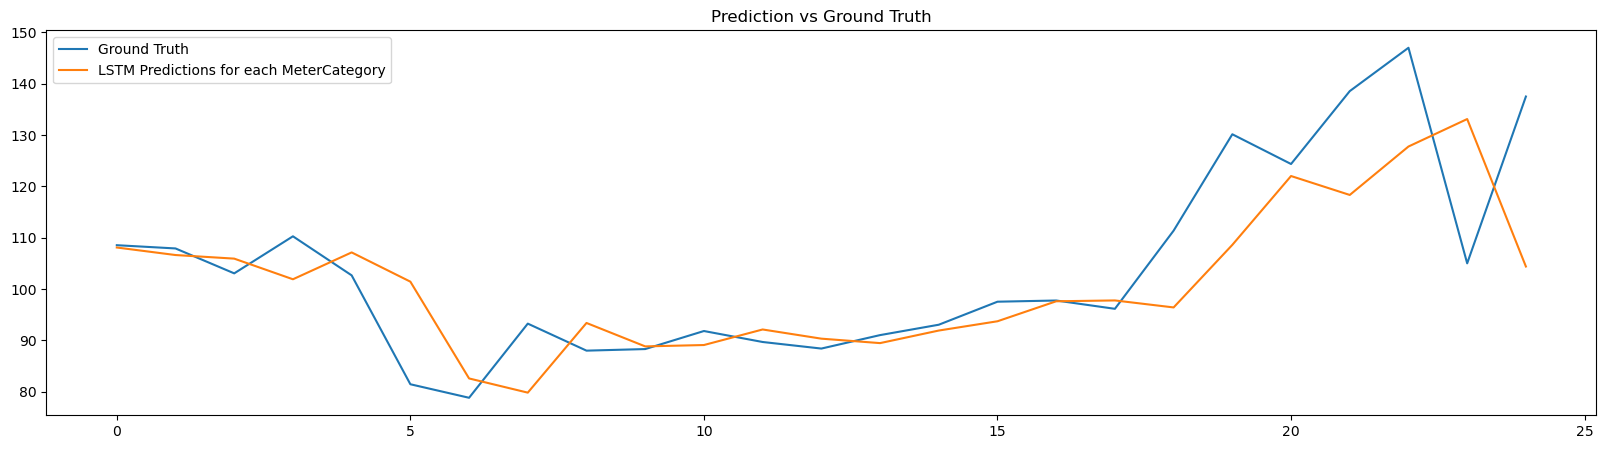

MDA = 0.6
RMSE = 12.836741212813928


In [132]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[9]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

## SIMPLE REGRESSOR STACKED DENSE LAYERS

In [158]:
predizioni_test = []
predizioni_val = []
MODELS_META = []
MDA_VAL_META = []
MDA_TEST_META = []
HISTORY_META = []

# meta_model
for i in range(20):

    preds_test = []
    preds_val = []

    mda_test = []
    mda_val = []

    history = 0 

    
    model = Sequential()
    model.add(InputLayer((10)))
    model.add(Dense(units=64, activation='LeakyReLU'))
    model.add(Dense(units=32, activation='LeakyReLU'))
    model.add(Dense(units=1, activation='linear'))
    
    """
    model = Sequential()
    model.add(InputLayer((9, 1)))
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(1))
    """

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    meta_model = model

    history_dict, meta_model = train_model(meta_model, train_x, train_y, val_x, val_y, cp)
    preds_test.append(model.predict(test_x))
    preds_val.append(model.predict(val_x))
    
    preds_test = np.array(preds_test)
    preds_val = np.array(preds_val)

    mda_test.append(da(test_y,preds_test.reshape(25)))
    mda_val.append(da(val_y,preds_val.reshape(10)))

    predizioni_test.append(preds_test)
    predizioni_val.append(preds_val)

    preds_test = []
    preds_val = []
    
    MODELS_META.append(meta_model)
    MDA_VAL_META.append(mda_val)
    MDA_TEST_META.append(mda_test)
    HISTORY_META.append(history_dict)

    mda_test = []
    mda_val = []


Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_141 (Dense)           (None, 64)                704       
                                                                 
 dense_142 (Dense)           (None, 32)                2080      
                                                                 
 dense_143 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 58ms/step
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 64)                704       
                                                                 
 dense_145 (Dense)           (None, 32)                2080      
                                                                 
 dense_146 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 16ms/step
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 64)                704       
                                                                 
 dense_148 (Dense)           (None, 32)                2080      
                                                                 
 dense_149 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 18ms/step
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 64)                704       
                                                                 
 dense_151 (Dense)           (None, 32)                2080      
                                                                 
 dense_152 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 56ms/step
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 64)                704       
                                                                 
 dense_154 (Dense)           (None, 32)                2080      
                                                                 
 dense_155 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 64)                704       
                                                                 
 dense_157 (Dense)           (None, 32)                2080      
                                                                 
 dense_158 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 17ms/step
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 64)                704       
                                                                 
 dense_160 (Dense)           (None, 32)                2080      
                                                                 
 dense_161 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 64)                704       
                                                                 
 dense_163 (Dense)           (None, 32)                2080      
                                                                 
 dense_164 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_165 (Dense)           (None, 64)                704       
                                                                 
 dense_166 (Dense)           (None, 32)                2080      
                                                                 
 dense_167 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 18ms/step
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 64)                704       
                                                                 
 dense_169 (Dense)           (None, 32)                2080      
                                                                 
 dense_170 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_171 (Dense)           (None, 64)                704       
                                                                 
 dense_172 (Dense)           (None, 32)                2080      
                                                                 
 dense_173 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 16ms/step
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 64)                704       
                                                                 
 dense_175 (Dense)           (None, 32)                2080      
                                                                 
 dense_176 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 17ms/step
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_177 (Dense)           (None, 64)                704       
                                                                 
 dense_178 (Dense)           (None, 32)                2080      
                                                                 
 dense_179 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 64)                704       
                                                                 
 dense_181 (Dense)           (None, 32)                2080      
                                                                 
 dense_182 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 16ms/step
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_183 (Dense)           (None, 64)                704       
                                                                 
 dense_184 (Dense)           (None, 32)                2080      
                                                                 
 dense_185 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 94ms/step
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 64)                704       
                                                                 
 dense_187 (Dense)           (None, 32)                2080      
                                                                 
 dense_188 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 16ms/step
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 64)                704       
                                                                 
 dense_190 (Dense)           (None, 32)                2080      
                                                                 
 dense_191 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 29ms/step
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 64)                704       
                                                                 
 dense_193 (Dense)           (None, 32)                2080      
                                                                 
 dense_194 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 17ms/step
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_195 (Dense)           (None, 64)                704       
                                                                 
 dense_196 (Dense)           (None, 32)                2080      
                                                                 
 dense_197 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 64)                704       
                                                                 
 dense_199 (Dense)           (None, 32)                2080      
                                                                 
 dense_200 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step


In [159]:
MDA_VAL_META

[[0.4444444444444444],
 [0.5555555555555556],
 [0.5555555555555556],
 [0.6666666666666666],
 [0.5555555555555556],
 [0.4444444444444444],
 [0.6666666666666666],
 [0.4444444444444444],
 [0.5555555555555556],
 [0.5555555555555556],
 [0.4444444444444444],
 [0.5555555555555556],
 [0.6666666666666666],
 [0.4444444444444444],
 [0.6666666666666666],
 [0.4444444444444444],
 [0.5555555555555556],
 [0.4444444444444444],
 [0.5555555555555556],
 [0.5555555555555556]]

In [160]:
MDA_TEST_META

[[0.5416666666666666],
 [0.625],
 [0.5833333333333334],
 [0.5416666666666666],
 [0.4583333333333333],
 [0.5416666666666666],
 [0.625],
 [0.5416666666666666],
 [0.625],
 [0.625],
 [0.5416666666666666],
 [0.5833333333333334],
 [0.5416666666666666],
 [0.5416666666666666],
 [0.5416666666666666],
 [0.5416666666666666],
 [0.625],
 [0.5416666666666666],
 [0.4583333333333333],
 [0.5416666666666666]]

In [136]:
def reshape_predictions(predictions_list):
    predictions_list = np.array(predictions_list)
    predictions_list = predictions_list.reshape(20,25)
    return predictions_list

### Plots

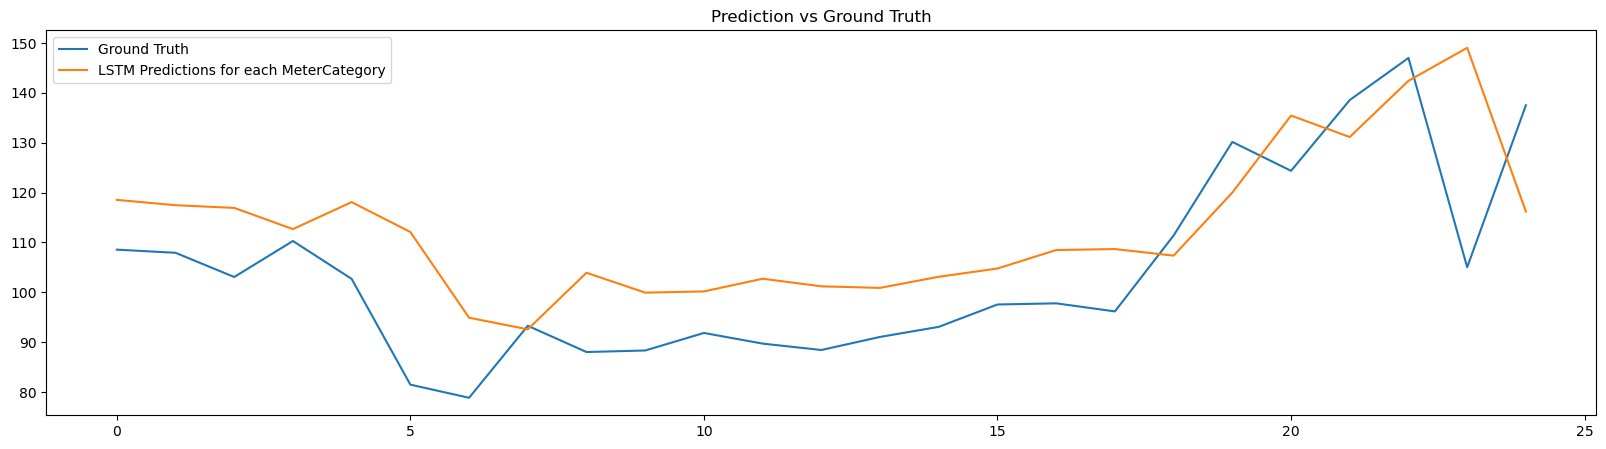

MDA = 0.52
RMSE = 15.287726478970704


In [161]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[0]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

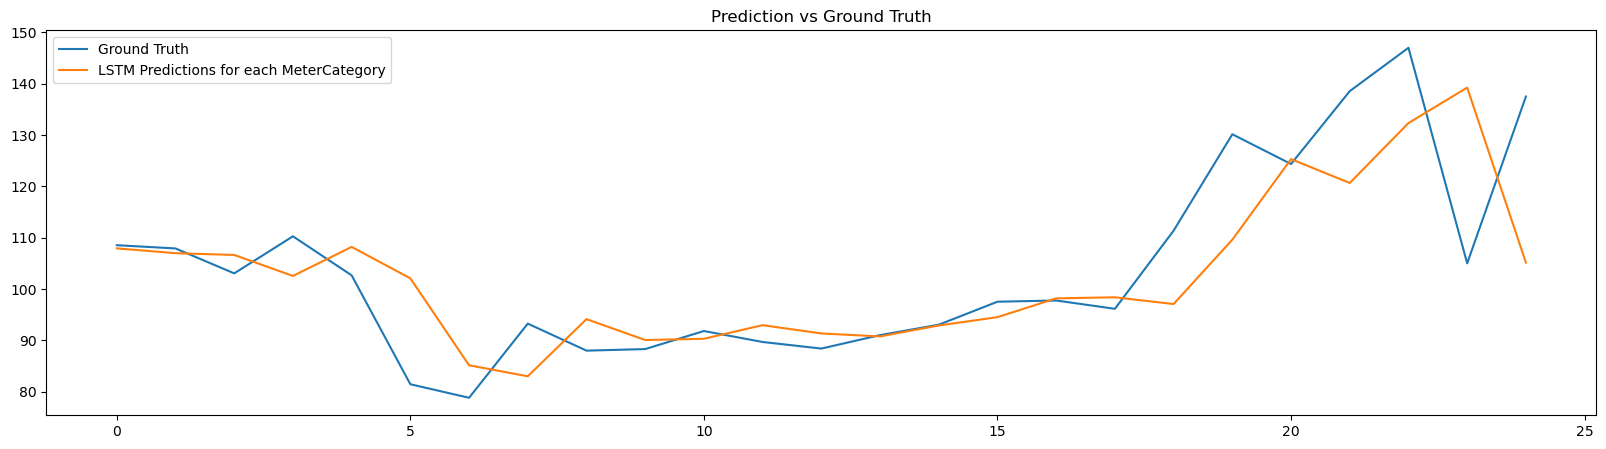

MDA = 0.64
RMSE = 12.85378478034125


In [162]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[1]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

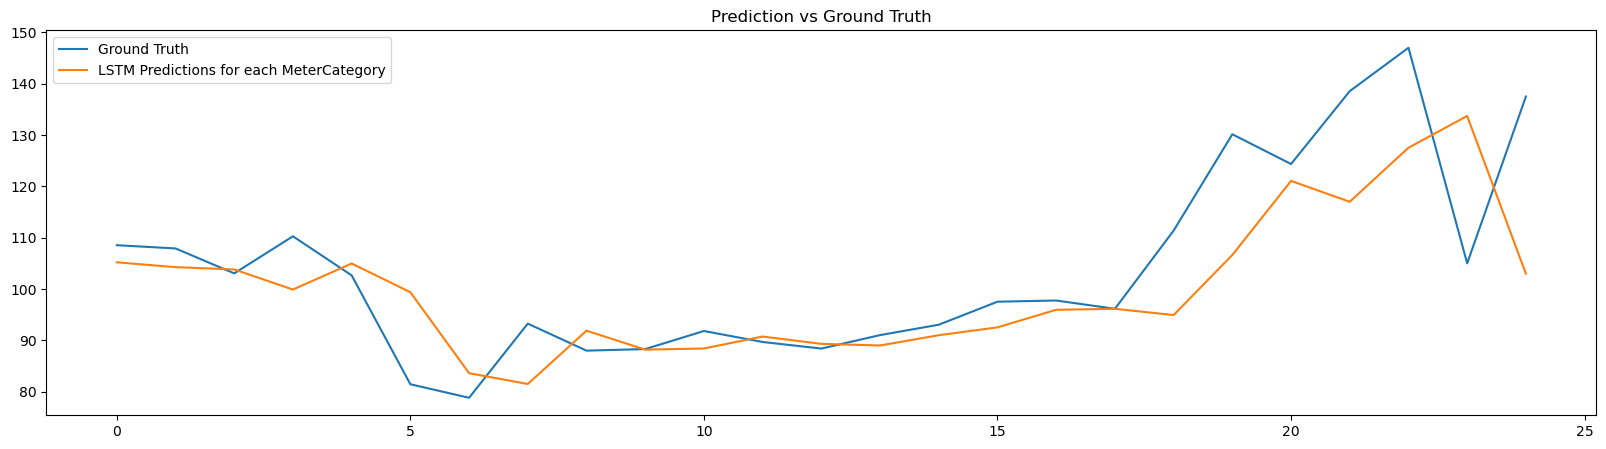

MDA = 0.6
RMSE = 13.233316427236279


In [163]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[2]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

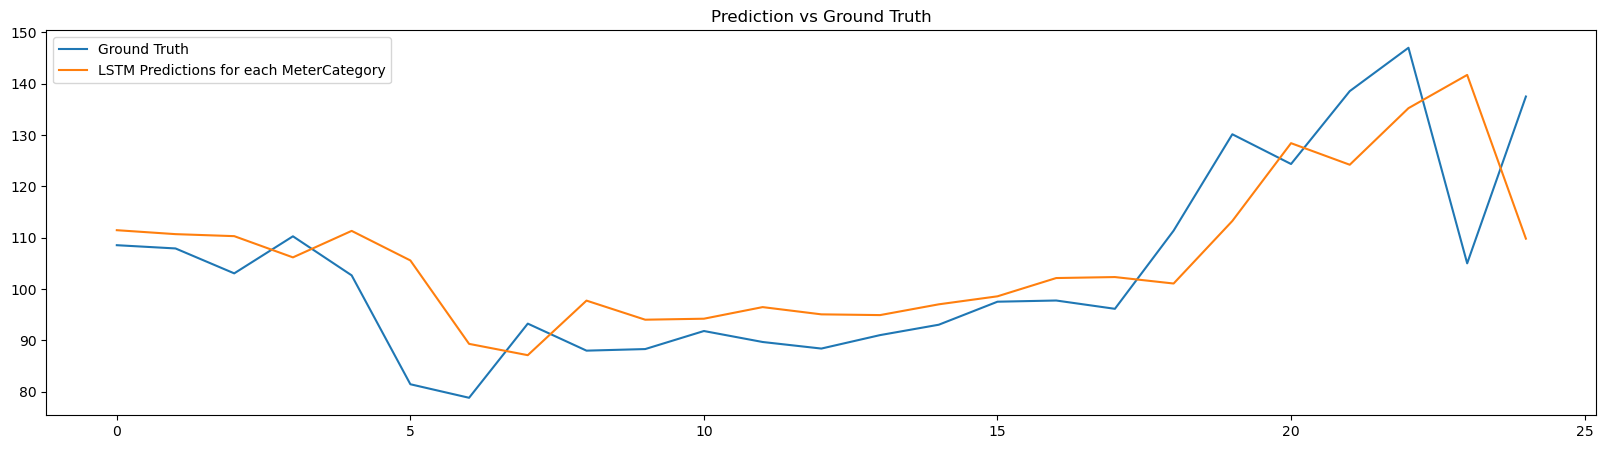

MDA = 0.52
RMSE = 12.75713095500399


In [164]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[3]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

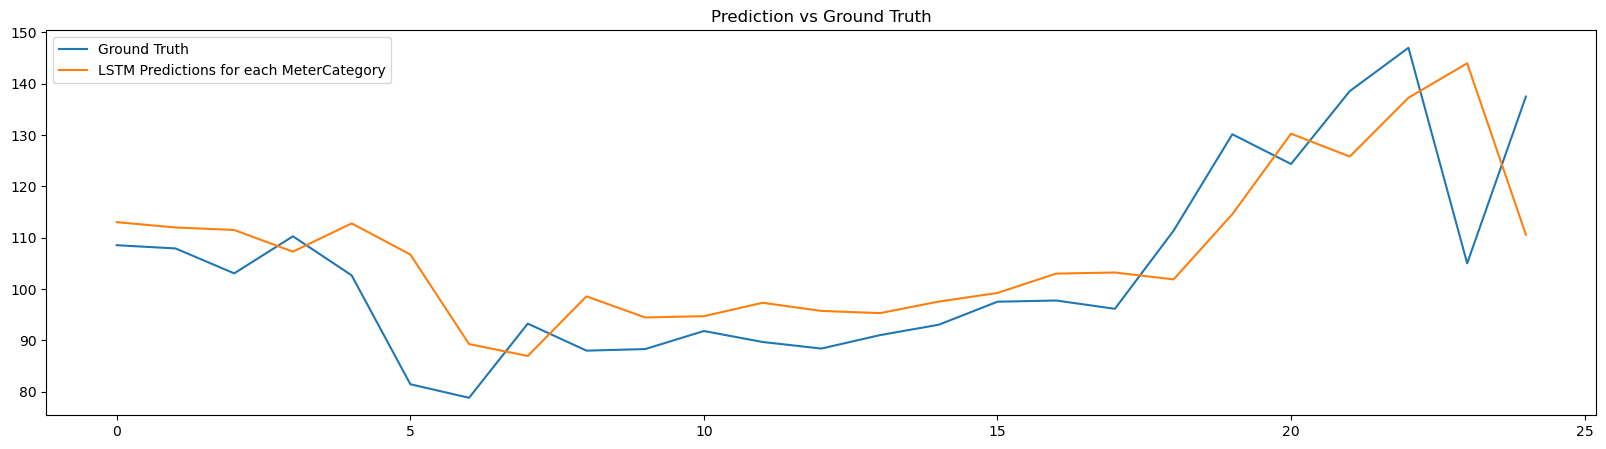

MDA = 0.52
RMSE = 13.056307996098598


In [141]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[4]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

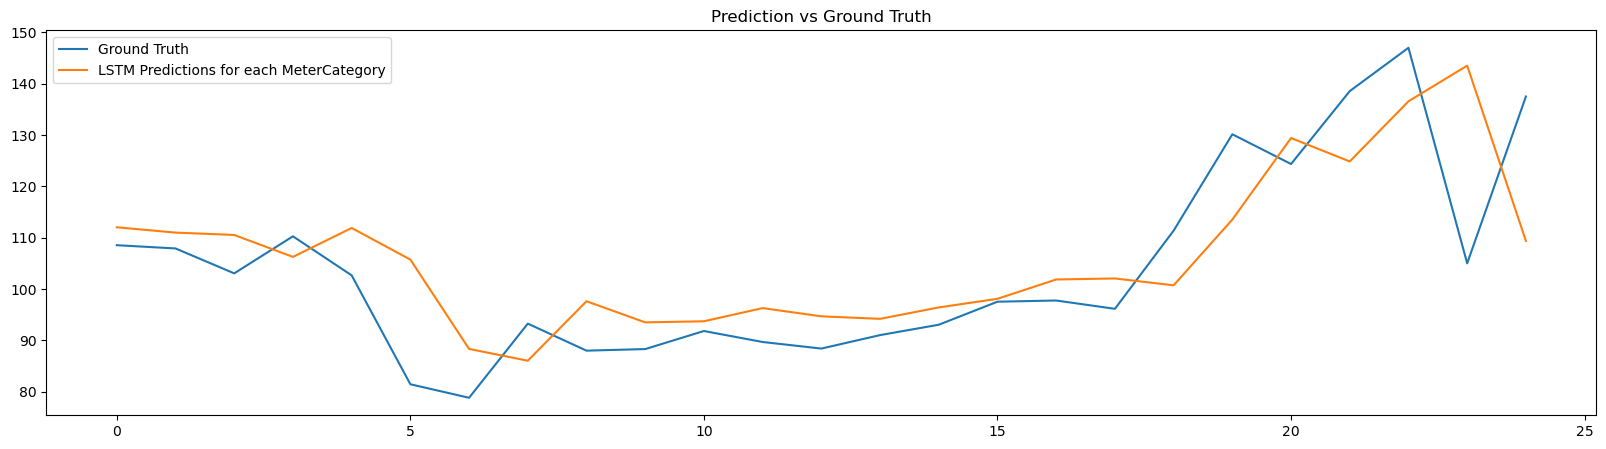

MDA = 0.56
RMSE = 12.923276144959551


In [142]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[5]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

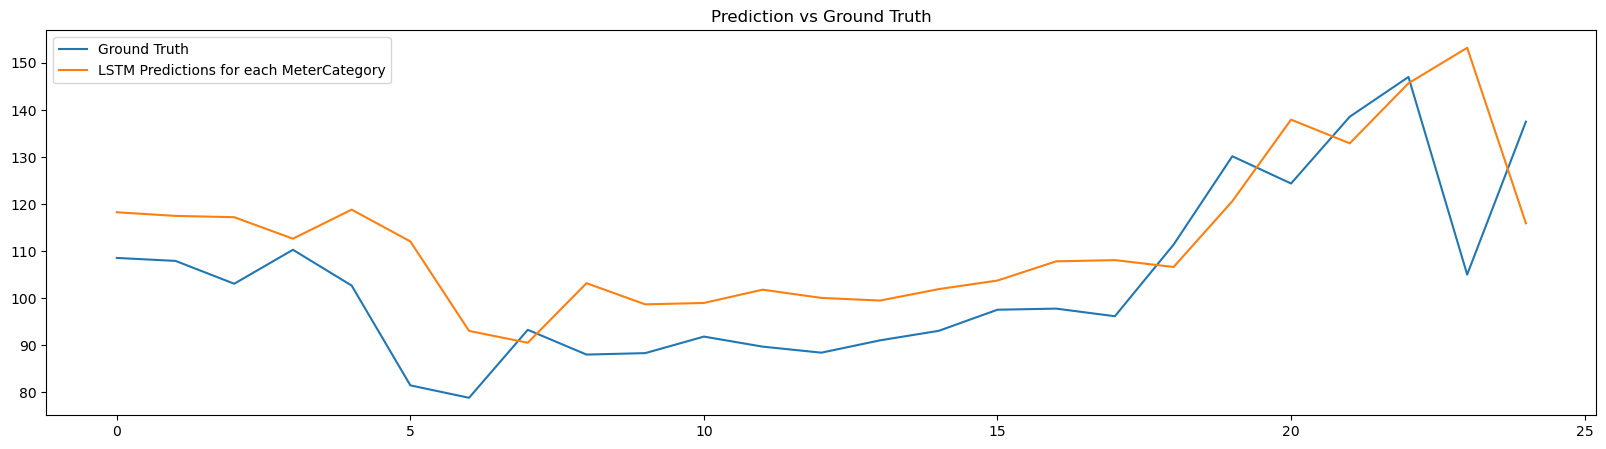

MDA = 0.52
RMSE = 15.516466179735144


In [143]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[6]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

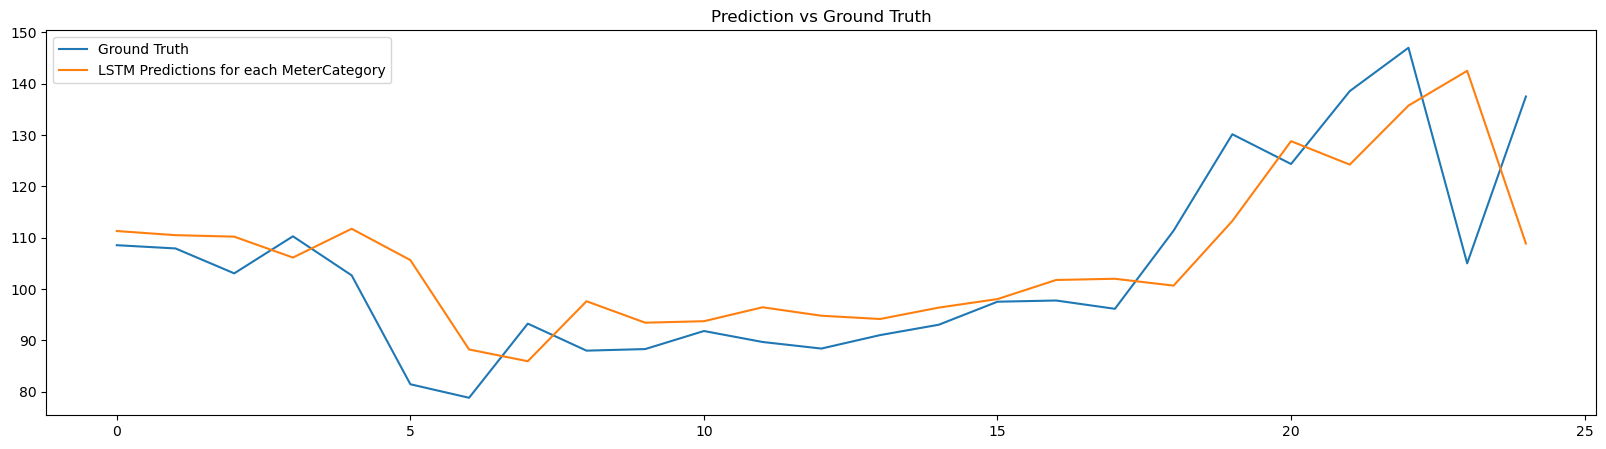

MDA = 0.52
RMSE = 12.882468109650162


In [144]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[7]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

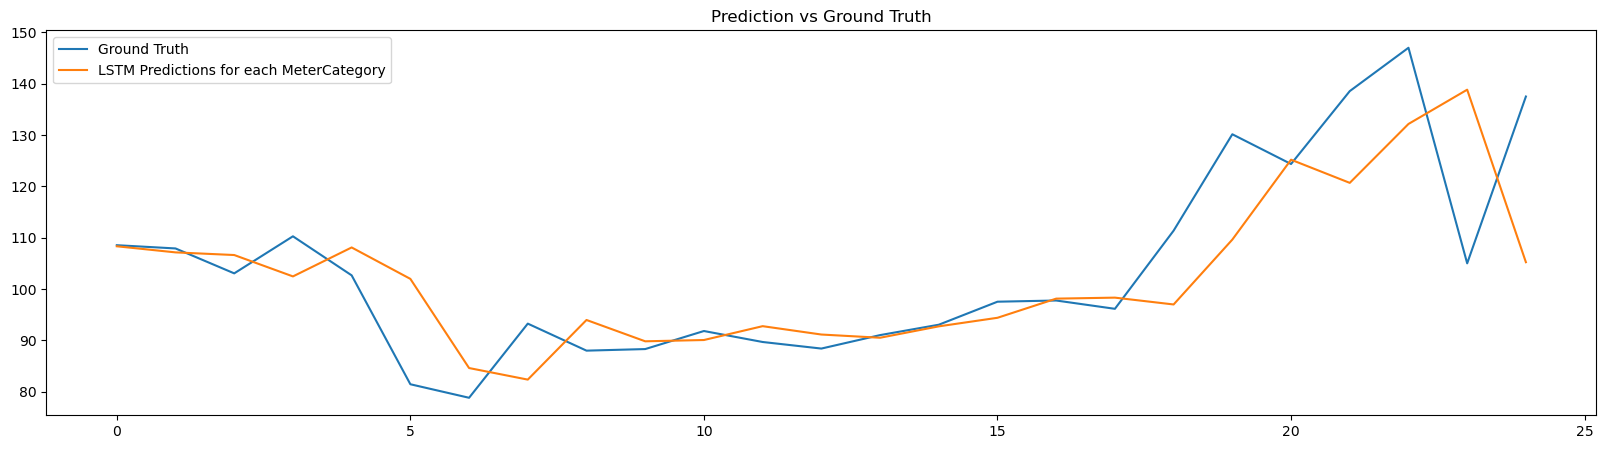

MDA = 0.64
RMSE = 12.81194642606806


In [145]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[8]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

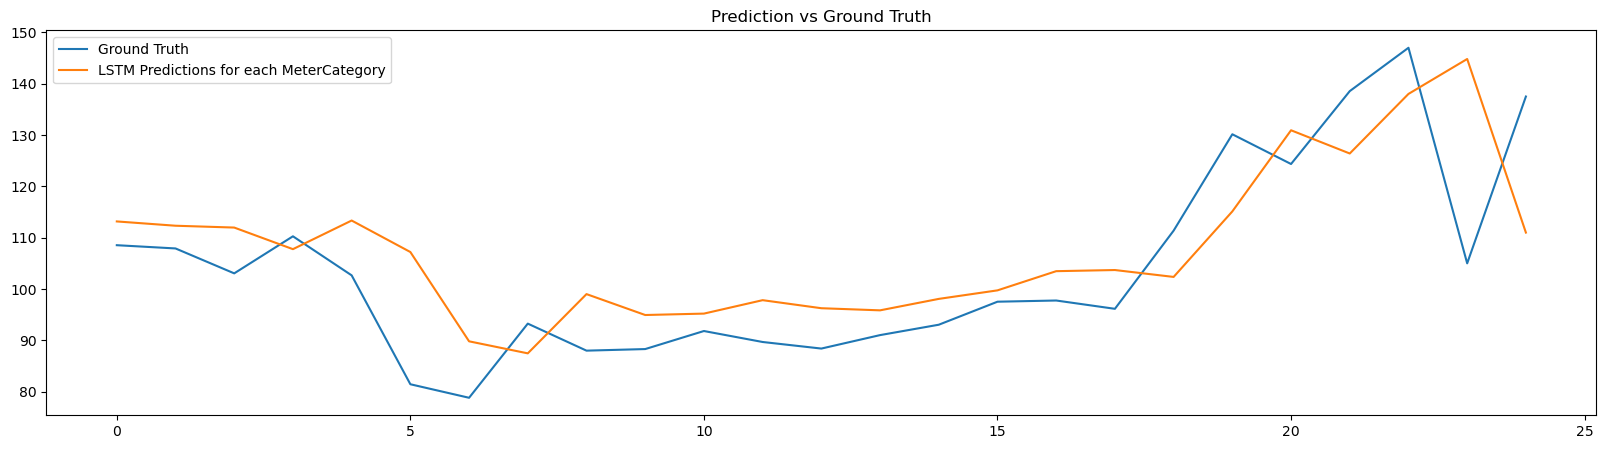

MDA = 0.52
RMSE = 13.22359381946537


In [146]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[9]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

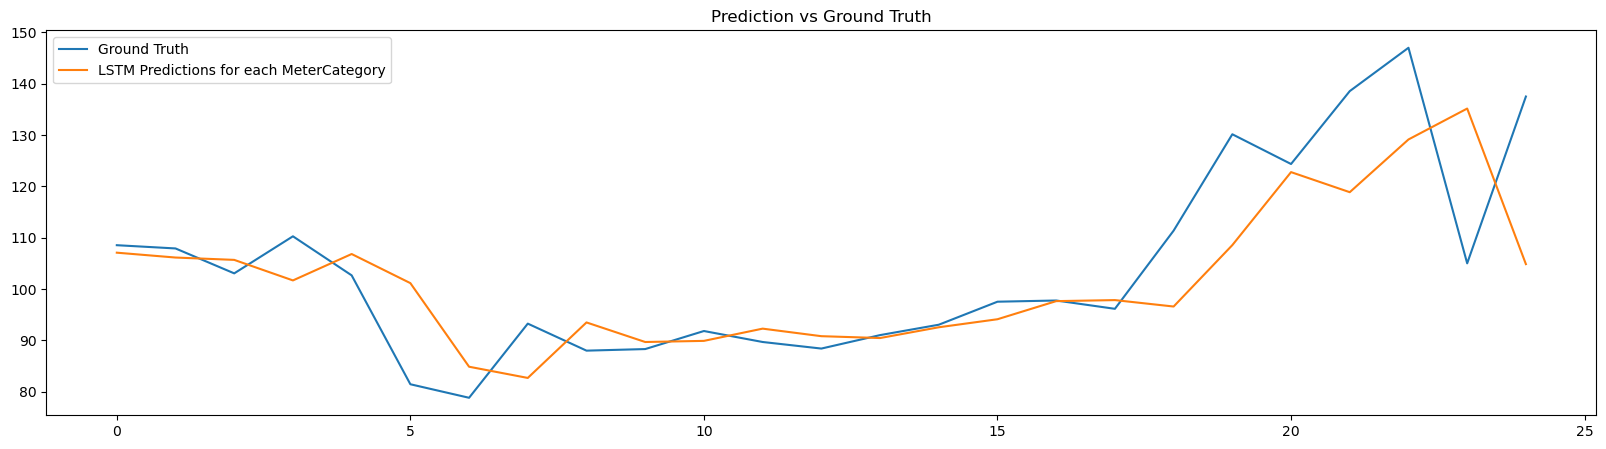

MDA = 0.6
RMSE = 12.760927764251349


In [147]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[10]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

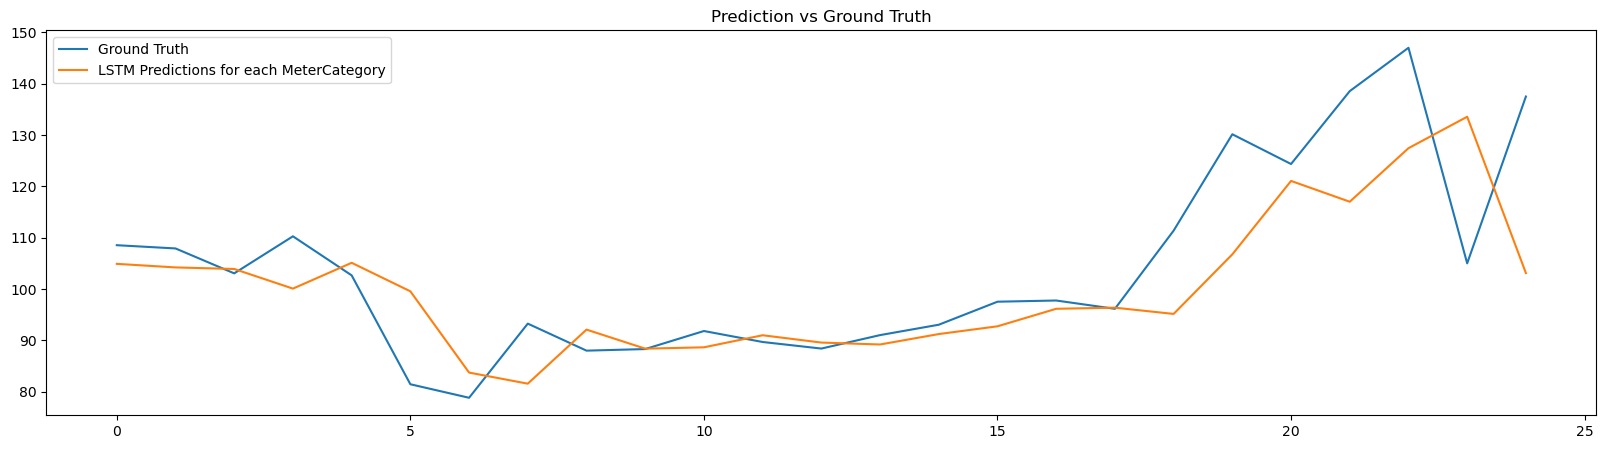

MDA = 0.64
RMSE = 13.195907244280074


In [148]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[11]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

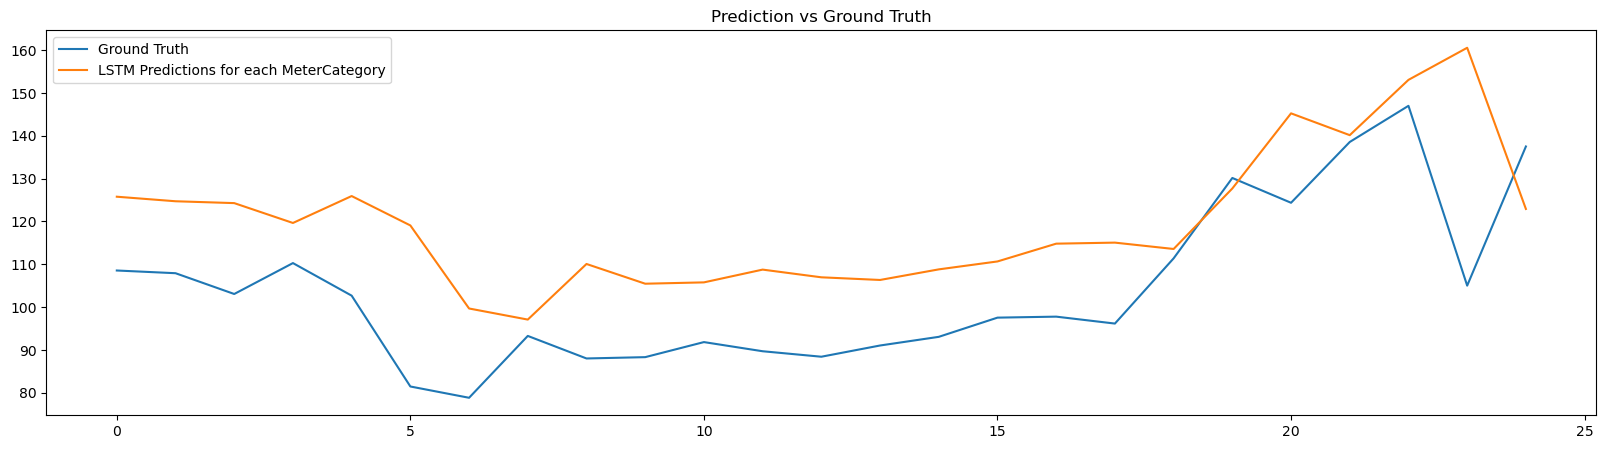

MDA = 0.52
RMSE = 20.286762115145894


In [149]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[12]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

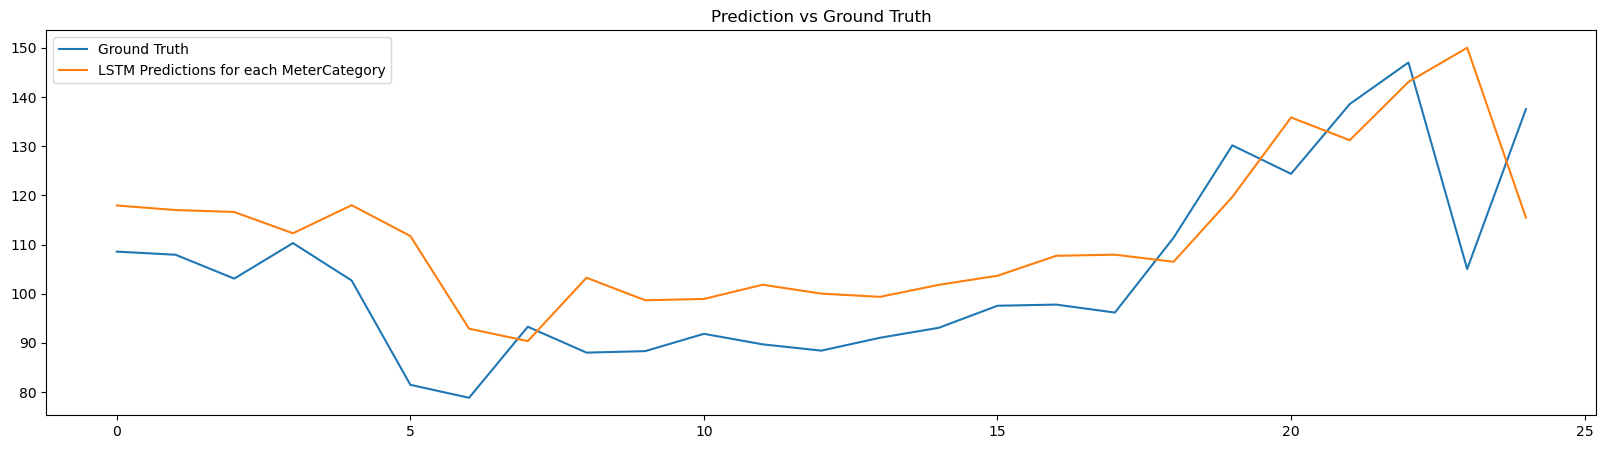

MDA = 0.52
RMSE = 15.029011007975743


In [150]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[13]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

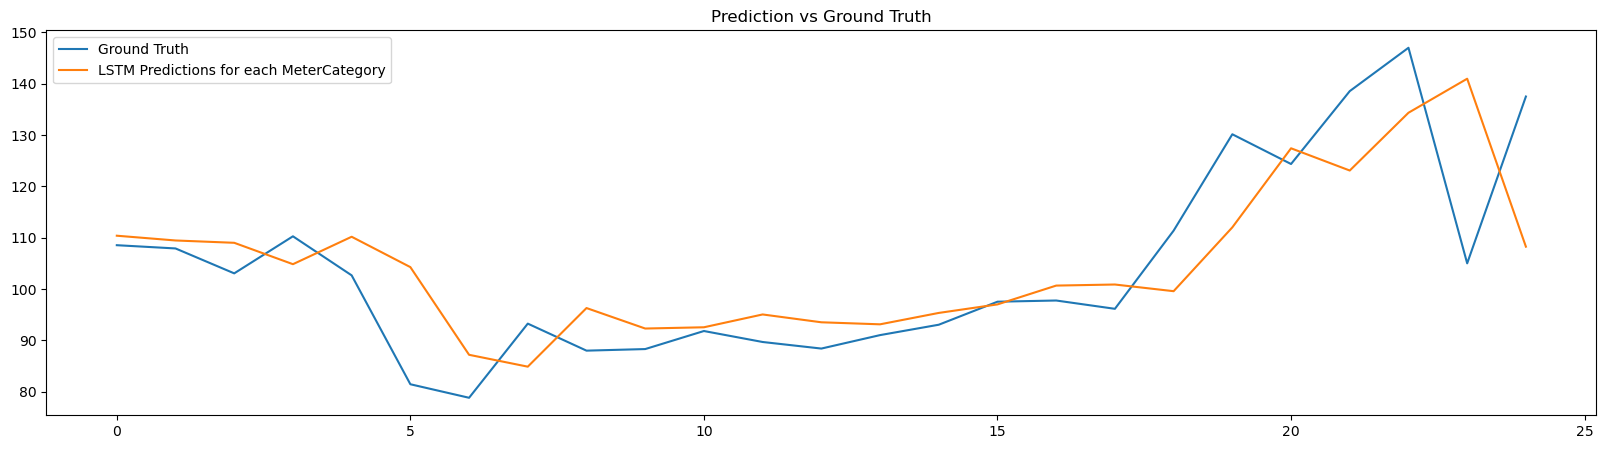

MDA = 0.56
RMSE = 12.639455661056605


In [151]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[14]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

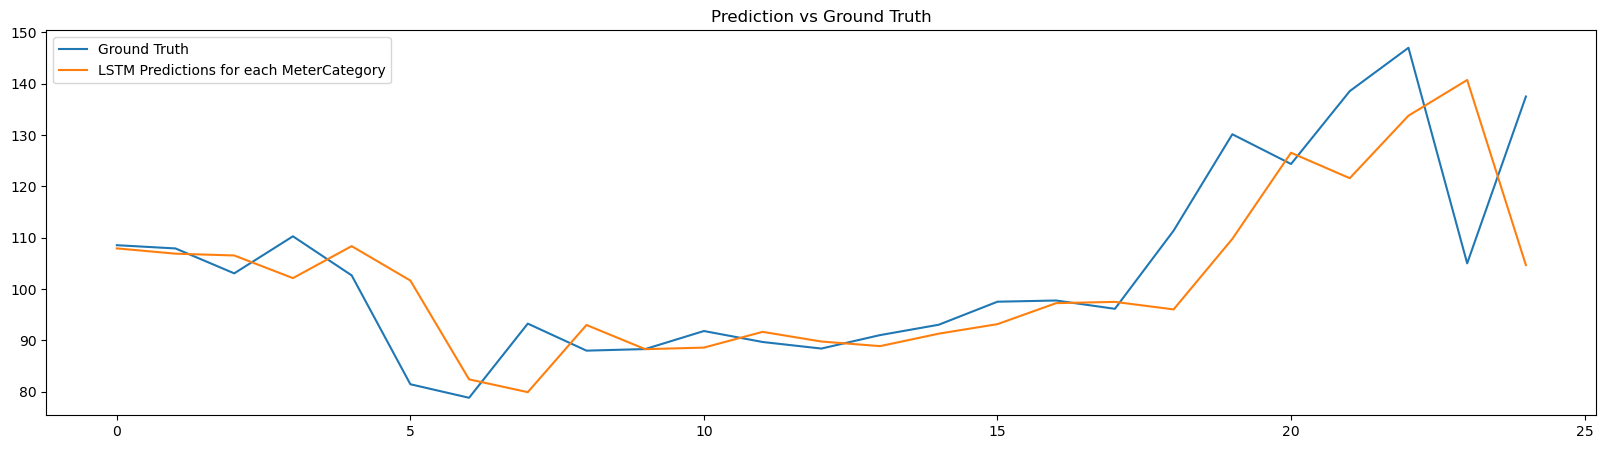

MDA = 0.64
RMSE = 13.041746881168603


In [152]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[15]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

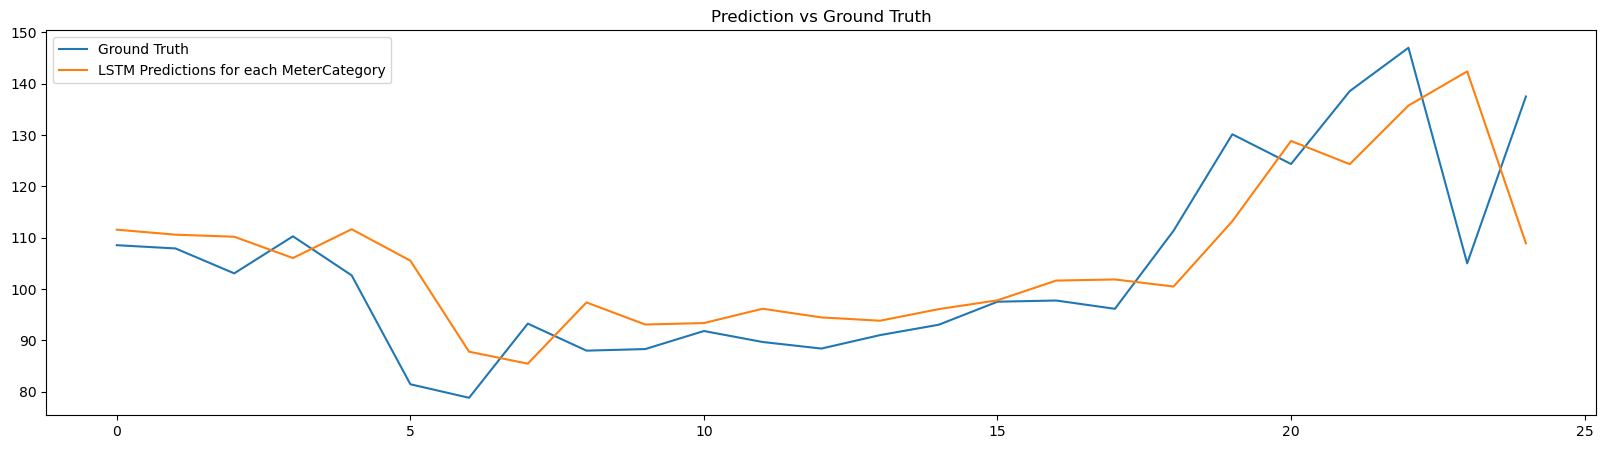

MDA = 0.52
RMSE = 12.826118215891038


In [153]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[16]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

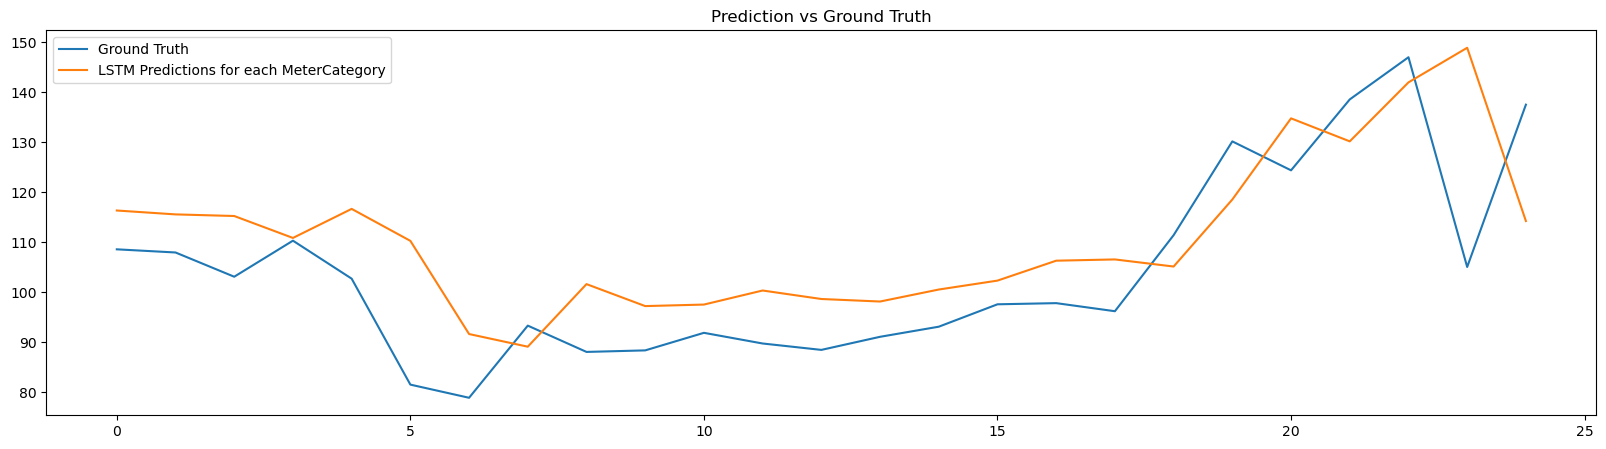

MDA = 0.52
RMSE = 14.33292094573351


In [154]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[17]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

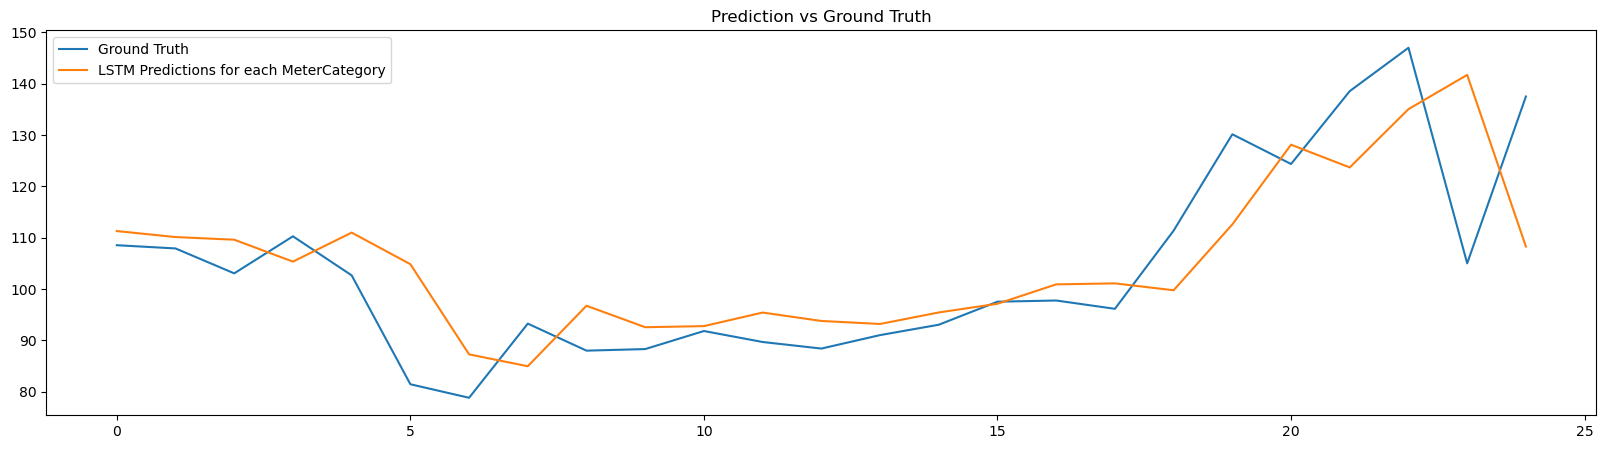

MDA = 0.52
RMSE = 12.74396427012596


In [155]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[18]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

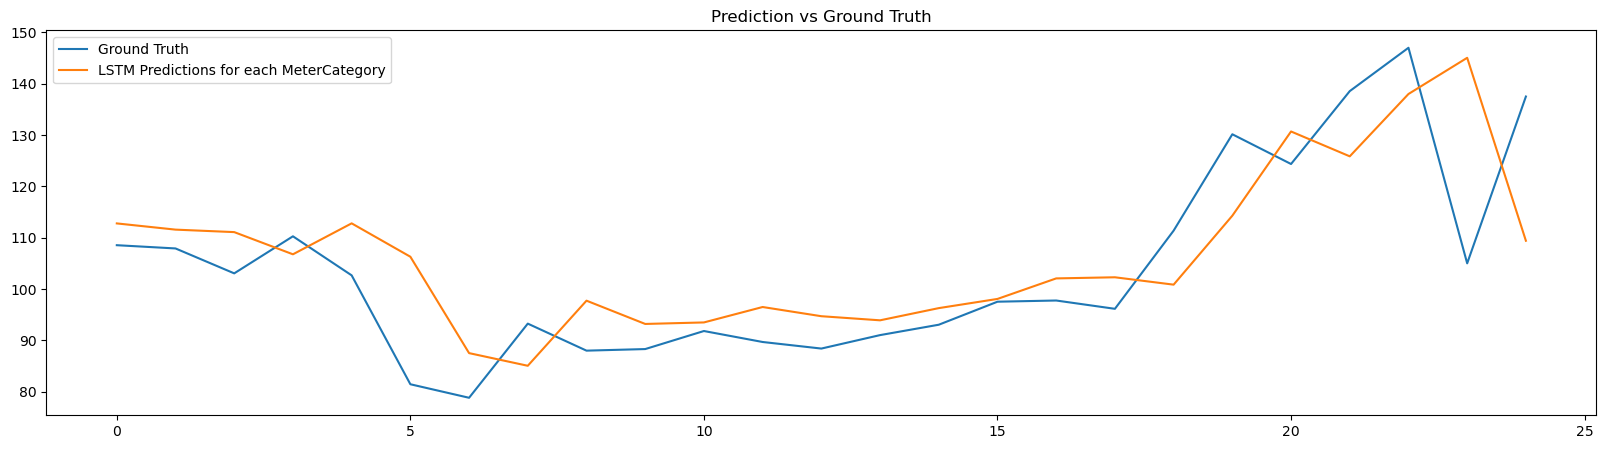

MDA = 0.52
RMSE = 13.099782594169755


In [156]:
predizioni_test_meta = reshape_predictions(predizioni_test)
predizioni_test_meta = predizioni_test_meta[19]
predizioni_test_meta = np.array(predizioni_test_meta)
predizioni_test_meta = np.insert(predizioni_test_meta, 0, 1)

pred_data = predizioni_test_meta
truth_data = test_truth

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data[1:], label="Ground Truth")
plt.plot(pred_data[1:], label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",np.sqrt(mean_squared_error(truth_data[1:], pred_data[1:])))

## XGB

In [86]:
reg = xgb.XGBRegressor( base_score=0.5,
                        booster='gbtree',
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01,
                        eval_metric = 'rmse'
                      )

In [87]:
reg.fit(train_x, train_y,
            eval_set=[(val_x, val_y)],
            verbose=100)

[0]	validation_0-rmse:125.18622
[100]	validation_0-rmse:46.23595
[200]	validation_0-rmse:20.57447
[300]	validation_0-rmse:13.08817
[400]	validation_0-rmse:11.16721
[500]	validation_0-rmse:10.85927
[600]	validation_0-rmse:10.68357
[665]	validation_0-rmse:10.70939


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [88]:
xgb_preds = reg.predict(test_x)

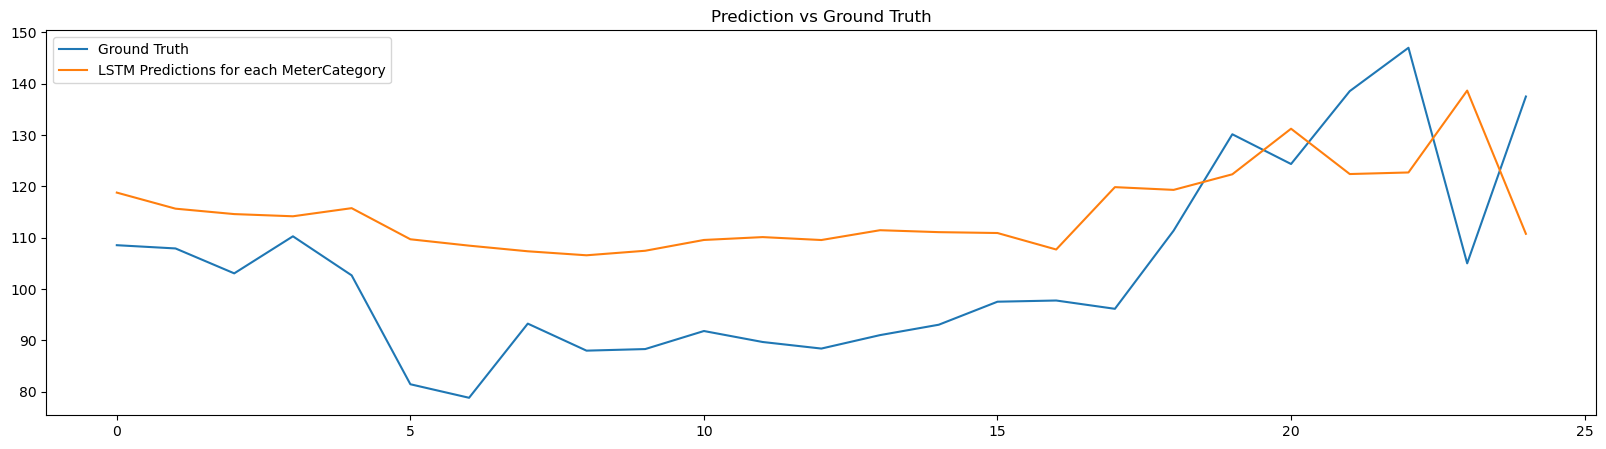

MDA = 0.5
RMSE = 18.65456919912039


In [89]:

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(test_y, label="Ground Truth")
plt.plot(xgb_preds, label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(test_y,xgb_preds))
print("RMSE =",np.sqrt(mean_squared_error(test_y, xgb_preds)))

## XGB Hyperparameter tuning (crasha il kernel, da eseguire su colab)

In [ ]:
def custom_loss(y_true, y_pred):

    rmse_w = 1
    da_w = 1

    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    # Calculate RMSE
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true)))

    # Calculate directional accuracy
    actual_diff = K.sign(y_true[1:] - y_true[:-1])
    pred_diff = K.sign(y_pred[1:] - y_true[:-1])
    num_correct = K.sum(K.cast(K.equal(actual_diff, pred_diff), tf.float32))
    total_comparisons = K.cast(K.shape(y_true)[0] - 1, tf.float32)
    da = num_correct / total_comparisons
    da = 1-da

    # Normalize RMSE and directional accuracy
    rmse_normalized = rmse / (K.max(y_true) - K.min(y_true))

    # Combine normalized RMSE and directional accuracy with weights
    loss = (rmse_normalized * rmse_w) + (da * da_w)

    return loss

In [ ]:
def objective(params):
    model = xgb.XGBRegressor(**params)
    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], verbose = False)
    preds = model.predict(test_x)

    loss = custom_loss(test_y, preds)

    return {'loss': loss, 'status': STATUS_OK}

In [ ]:
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
    'eval_metric':'rmse'
}

In [ ]:
# Perform the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

In [ ]:
# Perform the optimization
params = []
for i in range(10):
  trials = Trials()
  best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=300, trials=trials)
  best_params = {key: value for key, value in best.items()}
  params.append(best_params)

In [ ]:
best_model = xgb.XGBRegressor(**params[9], eval_metric = 'mape')
best_model.fit(train_x, train_y, eval_set=[(val_x, val_y)], verbose = False)

xgb_tuned_preds = best_model.predict(test_x)
# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(test_y, label="Ground Truth")
plt.plot(xgb_tuned_preds, label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(test_y,xgb_tuned_preds))
print("RMSE =",np.sqrt(mean_squared_error(test_y, xgb_tuned_preds)))